In [1]:
# import warnings
# warnings.simplefilter("ignore") # Warning 출력 방지

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

latent_dim = 100
height = 28
width = 28
channels = 1




# Generator
generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same')(x)
x = layers.Conv2D(128, 4, padding = 'same')(x)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.LeakyReLU()(x) # Leaky ReLU 랑 비교
x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same')(x)
x = layers.Conv2D(64, 4, padding = 'same')(x)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)

generator = Model(generator_input, x)
generator.summary()





# Discriminator
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(discriminator_input)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 4, strides = 2, padding = 'same')(x)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 4, strides = 2, padding = 'same')(x)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, 4, strides = 1, padding = 'same')(x)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator_optimizer = Adam(lr = 0.0002, beta_1 = 0.5) # beta_1 : The exponential decay rate for the 1st moment estimates. Defaults to 0.9.
discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
discriminator.summary()





# GAN Model Definition
gan_input = layers.Input(shape = (latent_dim,))

discriminator.trainable = False # Discriminator 학습하지 않도록 설정
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])





# GAN Model Training
(x_train, _), (_, _) = mnist.load_data()

x_train = x_train.astype(np.float32) / 127.5-1 # Generator의 마지막 activation function에서 'tanh'를 사용했으므로, (-1 ~ 1)로 scaling
x_train = np.expand_dims(x_train, axis = -1)

batch_size = 32

def train(epochs, print_step = 100):
    history = []
    for epoch in range(epochs):

        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)] # 실제 이미지를 index 0~60000 사이 균일분포에서 batch_size 만큼 sampling
        real_label = np.ones((batch_size, 1))

        # Image Generation
        noise = np.random.normal(0, 1, size = (batch_size, latent_dim)) # numpy.random.normal(loc(centre), scale(standard deviation), size)
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))

        # Label Noise addition
        real_label += 0.05 * np.random.normal(0, 1, size = real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size = fake_label.shape)

        # Discriminator Learning
        d_loss_real = discriminator.train_on_batch(real_images, real_label) # train_on_batch를 사용하여 하나의 데이터 배치에 대해서 경사 업데이트를 1회 실시
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Add arguments(real, fake losses) element-wise.

        # Generator Learning
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Recording
        record = (epoch, d_loss[0], g_loss[0])
        history.append(record)

        if epoch % print_step == 0:
            print("Epoch : %5d / D Loss : %.4f, G Loss : %.4f" %record)
        
    return history

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 128)       0     

In [6]:
%%time
history500 = train(500, 100)

Epoch :     0 D Loss : 0.0266, G Loss : 0.2188
Epoch :   100 D Loss : -0.0964, G Loss : 2.5960
Epoch :   200 D Loss : -0.0760, G Loss : 0.4263
Epoch :   300 D Loss : 0.0481, G Loss : 0.6049
Epoch :   400 D Loss : -0.0968, G Loss : 0.0880
CPU times: user 25.4 s, sys: 1.43 s, total: 26.9 s
Wall time: 25.8 s


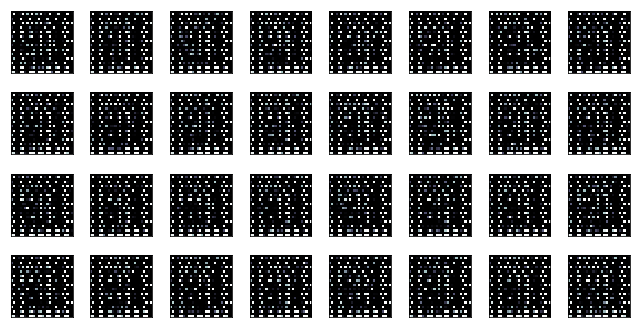

In [7]:
import matplotlib.pyplot as plt

def show_images(generated_images, n=4, m=8, figsize=(9,5)):
    fig = plt.figure(figsize = figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05) # Tune the subplot layout.
    # the amount of width/height reserved for space between subplots, expressed as a fraction of the average axis width/height
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1) # Add an Axes to the figure as part of a subplot arrangement.
            ax.imshow(generated_images[k][:, :, 0], cmap = plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([]) # 눈금을 비워두고 축 눈금과 레이블을 보이지 않게 한다. (축 레이블은 영향을 받지 않는다)
            ax.yaxis.set_ticks([])
    plt.tight_layout() # Automatically adjust subplot parameters to give specified padding.
    plt.show()

noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5)

Epoch :     0 D Loss : -0.1189, G Loss : 1.6467
Epoch :   500 D Loss : 0.0969, G Loss : 0.8581
Epoch :  1000 D Loss : -0.0039, G Loss : 0.1149
Epoch :  1500 D Loss : 0.2228, G Loss : 10.0958
Epoch :  2000 D Loss : 0.2034, G Loss : 0.2961
Epoch :  2500 D Loss : -0.0409, G Loss : 8.1253
Epoch :  3000 D Loss : -0.1068, G Loss : 0.0001
Epoch :  3500 D Loss : -0.0582, G Loss : 0.6574
Epoch :  4000 D Loss : -0.0068, G Loss : 8.0158


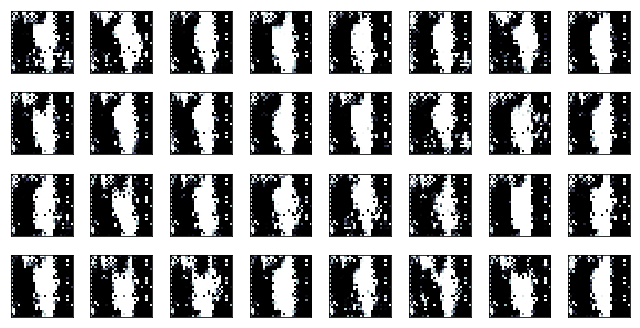

CPU times: user 3min 50s, sys: 12.9 s, total: 4min 3s
Wall time: 3min 54s


In [8]:
%%time
history5000 = train(4500, 500)
show_images(0.5 * generator.predict(noise_data) + 0.5)